In [1]:
import pandas as pd
import numpy as np
import time

import scanpy as sc
from anndata.experimental.pytorch import AnnLoader

import pretty_confusion_matrix as pcm

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchnet.meter import ClassErrorMeter, AverageValueMeter
# from torch_prototypes.modules import prototypical_network
import prototypical_network
from torch_prototypes.metrics import distortion, cost
from torch_prototypes.metrics.distortion import DistortionLoss
from  torch.distributions import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

import helper_fns

import igraph as ig
from sklearn.decomposition import TruncatedSVD
from anndata import AnnData

In [35]:
# --------------Parameters-------------------
embedding_dim = 10
hidden_dim = 512
k_fold = 5
cross_validation = False
num_epoch=100
batch_size=128
feature_selection = True
num_genes = 36601
mode = 'Net'
# --------------Plotting---------------------
plot_loss = False
plot_embedding_space = False
plot_confusion_matrix = True

In [3]:
dataset = sc.read('filtered_data_500.h5ad')
encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset.obs['Manually_curated_celltype'])

list_ct = dataset.obs['Manually_curated_celltype'].unique().tolist()
list_num_ct = encoder_celltype.transform(list_ct)
list_inner_nodes = ['Cross-tissue Immune Cell Atlas', 'B cell', 'Germinal center B cell', 'Myeloid', 'Dendritic cell',
                    'Macrophages', 'Monocytes', 'T & Innate lymphoid cells', 'CD4', 'T Naive', 'CD8', 
                    'Tissue-resident memory T (Trm) cells', 'NK']
all_nodes = list_ct + list_inner_nodes

encoder_celltype_inner = LabelEncoder()
encoder_celltype_inner.fit(list_inner_nodes)

def transfrom(x):
    if x in list_inner_nodes:
        return encoder_celltype_inner.transform([x])[0] + len(list_ct)
    else:
        return encoder_celltype.transform([x])[0]

encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype.transform
    }
}

g = ig.Graph()
g.add_vertices(len(all_nodes))
g.vs['name'] = np.append(encoder_celltype.inverse_transform(list(range(len(list_ct)))), encoder_celltype_inner.inverse_transform(list(range(len(list_inner_nodes)))))
g.add_edges([(transfrom('Cross-tissue Immune Cell Atlas'), transfrom('B cell')),
             (transfrom('Cross-tissue Immune Cell Atlas'), transfrom('Myeloid')),
             (transfrom('Cross-tissue Immune Cell Atlas'), transfrom('T & Innate lymphoid cells'))])
g.add_edges([(transfrom('B cell'), transfrom('ABCs')),
             (transfrom('B cell'), transfrom('Germinal center B cell')),
             (transfrom('B cell'), transfrom('Memory B cells')),
             (transfrom('B cell'), transfrom('Naive B cells')),
             (transfrom('B cell'), transfrom('Plasma cells')),
             (transfrom('B cell'), transfrom('Plasmablasts')),
             (transfrom('B cell'), transfrom('Pre-B')),
             (transfrom('B cell'), transfrom('Pro-B'))])
g.add_edges([(transfrom('Germinal center B cell'), transfrom('GC_B (I)')),
             (transfrom('Germinal center B cell'), transfrom('GC_B (II)'))])
g.add_edges([(transfrom('Myeloid'), transfrom('Cycling')),
             (transfrom('Myeloid'), transfrom('Dendritic cell')),
             (transfrom('Myeloid'), transfrom('Macrophages')),
             (transfrom('Myeloid'), transfrom('Monocytes'))])
g.add_edges([(transfrom('Dendritic cell'), transfrom('DC1')),
             (transfrom('Dendritic cell'), transfrom('DC2')),
             (transfrom('Dendritic cell'), transfrom('migDC'))])
g.add_edges([(transfrom('Macrophages'), transfrom('Alveolar macrophages')),
             (transfrom('Macrophages'), transfrom('Erythrophagocytic macrophages')),
             (transfrom('Macrophages'), transfrom('Intermediate macrophages')),
             (transfrom('Macrophages'), transfrom('Intestinal macrophages'))])
g.add_edges([(transfrom('Monocytes'), transfrom('Classical monocytes')),
             (transfrom('Monocytes'), transfrom('Nonclassical monocytes'))])
g.add_edges([(transfrom('T & Innate lymphoid cells'), transfrom('CD4')),
             (transfrom('T & Innate lymphoid cells'), transfrom('CD8')),
             (transfrom('T & Innate lymphoid cells'), transfrom('Cycling T&NK')),
             (transfrom('T & Innate lymphoid cells'), transfrom('ILC3')),
             (transfrom('T & Innate lymphoid cells'), transfrom('NK')),
             (transfrom('T & Innate lymphoid cells'), transfrom('T_CD4/CD8'))])
g.add_edges([(transfrom('CD4'), transfrom('T Naive')),
             (transfrom('CD4'), transfrom('Teffector/EM_CD4')),
             (transfrom('CD4'), transfrom('Tfh')),
             (transfrom('CD4'), transfrom('Tregs')),
             (transfrom('CD4'), transfrom('Trm_Th1/Th17'))])
g.add_edges([(transfrom('CD8'), transfrom('MAIT')),
             (transfrom('CD8'), transfrom('Tem/emra_CD8')),
             (transfrom('CD8'), transfrom('Tgd_CRTAM+')),
             (transfrom('CD8'), transfrom('Tissue-resident memory T (Trm) cells')),
             (transfrom('CD8'), transfrom('Tnaive/CM_CD8')),
             (transfrom('CD8'), transfrom('Trm_Tgd'))])
g.add_edges([(transfrom('NK'), transfrom('NK_CD16+')),
             (transfrom('NK'), transfrom('NK_CD56bright_CD16-'))])
g.add_edges([(transfrom('T Naive'), transfrom('Tnaive/CM_CD4')),
             (transfrom('T Naive'), transfrom('Tnaive/CM_CD4_activated'))])
g.add_edges([(transfrom('Tissue-resident memory T (Trm) cells'), transfrom('Trm/em_CD8')),
             (transfrom('Tissue-resident memory T (Trm) cells'), transfrom('Trm_gut_CD8')),])

# g.write('tree', format='gml')
layout = g.layout("kamada_kawai")
ig.plot(g, layout=layout, vertex_label=g.vs["name"], vertex_label_size=10, vertex_size=15, bbox=(1000, 1000), margin=100, vertex_color='white')

def get_shortest_dist(node_1, node_2, graph):
    return len(graph.get_shortest_paths(node_1, node_2)[0])-1

dist_df = pd.DataFrame(0, index=np.arange(len(list_num_ct)), columns=np.arange(len(list_num_ct)))
for i in range(len(list_num_ct)):
    for j in range(len(list_num_ct)):
        dist_df.iloc[i, j]=get_shortest_dist(i, j, g)

D = dist_df
D = torch.tensor(D.values, dtype=float)

train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset, cross_validation=cross_validation, k_fold=k_fold)
sc.pp.normalize_total(dataset, 1e4)
sc.pp.log1p(dataset)
pca = TruncatedSVD(n_components=128)
pca.fit(dataset[train_indices].X)
dataset_pca = AnnData(pca.transform(dataset.X))
dataset_pca.obs = dataset.obs
dataset = dataset_pca

train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

In [41]:
class PL(nn.Module):
    def __init__(self, centers):
        super(PL, self).__init__()
        self.centers = centers

    def forward(self, mapping, labels):
        targets = torch.index_select(self.centers, 0, labels)
        dist = torch.norm(mapping - targets, dim=1)
        dist = torch.sum(dist)
        return dist/mapping.shape[0]

# Pytorch version of the 3 fully connected layers
class Net(nn.Module):
    def __init__(self, mode, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.mode = mode
        self.fc1 = nn.Linear(input_size, hidden_size)
        # self.dropout = nn.Dropout(0.2)
        # self.fc2 = nn.Linear(hidden_size, hidden_size)
        if mode == 'Net':
            self.fc3 = nn.Linear(hidden_size, output_size)
        else:
            self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        if self.mode == 'Net':
            x = F.softmax(x, dim=1)
        return x

In [42]:
def train_nn(mode, l_metric=1, l_pl=3, epochs=num_epoch, D_metric=None, D_cost=D, cuda=1):
    D_metric = D_metric.cuda()
    if mode == 'Proto_Net':
        model = Net(mode, 128, 32, embedding_dim).cuda()
        model = prototypical_network.LearntPrototypes(model, n_prototypes= D_metric.shape[0],
            prototypes=None, embedding_dim=embedding_dim, device='cuda').cuda()
    if mode == 'Net':
        model = Net(mode, 128, 32, D_metric.shape[0]).cuda()
    
    delta = DistortionLoss(D_metric)
    criterion = nn.CrossEntropyLoss()
    ac = cost.AverageCost(D_cost)

    opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    if plot_loss:
        loss_xe = []
        loss_disto = []
        loss_pl = []
    if plot_embedding_space:
        training_embeddings = []
        training_labels = []
        testing_embeddings = []
        testing_pred_labels = []
        testing_true_labels = []
    for epoch in range(1, epochs+1):
        print('Epoch {}'.format(epoch))
        ER_meter = ClassErrorMeter(accuracy=False)
        AC_meter = AverageValueMeter()

        model.train()
        t0 = time.time()
        if plot_loss:
            batch_xe = []
            batch_disto = []
            batch_pl = []
        for batch in dataloader_training:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            if mode == 'Net':
                out = model(x)
            elif mode == 'Proto_Net':
                out, embeddings = model(x)            
                pl_loss = PL(centers = model.prototypes.data)
                pl_loss_ = pl_loss(embeddings, y)
            opt.zero_grad()
            if epoch == epochs and plot_embedding_space:
                training_embeddings.extend(embeddings)
                training_labels.extend(y)
            if mode == 'Net':
                loss = criterion(out, y)
            elif mode == 'Proto_Net':
                loss = criterion(out, y) + l_metric * delta(model.prototypes) + l_pl*pl_loss_
            
            if plot_loss:
                batch_xe.append(criterion(out, y).detach().cpu())
                batch_disto.append((l_metric * delta(model.prototypes)).detach().cpu())
                batch_pl.append(l_pl*pl_loss_.detach().cpu())

            loss.backward()
            opt.step()
            pred = out.detach()
            ER_meter.add(pred.cpu(),y.cpu())
            AC_meter.add(ac(pred.cpu(),y.cpu()))
        
        if plot_loss:
            loss_xe.append(np.array(batch_xe).mean())
            loss_disto.append(np.array(batch_disto).mean())
            loss_pl.append(np.array(batch_pl).mean())

            
        t1 = time.time()
        # log[epoch] = {'train_ER':ER_meter.value()[0], 'train_AC':AC_meter.value()[0], 'train_time':t1-t0}
        
        print('Train ER {:.2f}, AC {:.3f}, time {:.1f}s'.format(ER_meter.value()[0], AC_meter.value()[0], t1-t0))

        model.eval()
        ER_meter = ClassErrorMeter(accuracy=False)
        AC_meter = AverageValueMeter()
        t0 = time.time()
        for batch in dataloader_testing:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            if mode == 'Net':
                with torch.no_grad():
                    out = model(x)
            elif mode == 'Proto_Net':
                with torch.no_grad():
                    out, embedding_y = model(x)
            pred = out.detach()
            if epoch == epochs and plot_embedding_space:
                testing_embeddings.extend(embedding_y)
                testing_pred_labels.extend(pred.cpu().numpy())
                testing_true_labels.extend(y)
            ER_meter.add(pred.cpu(),y)
            AC_meter.add(ac(pred.cpu(),y))
        t1 = time.time()
        print('Test ER {:.2f}, AC {:.3f}, time {:.1f}s'.format(ER_meter.value()[0], AC_meter.value()[0], t1-t0))
        results = {}
        results['model'] = model
        if plot_loss:
            results['loss_xe'] = loss_xe
            results['loss_disto'] = loss_disto
            results['loss_pl'] = loss_pl
        if plot_embedding_space:
            results['training_embeddings'] = training_embeddings
            results['training_labels'] = training_labels
            results['test_embeddings'] = testing_embeddings
            results['test_true_labels'] = testing_true_labels
            results['test_pred_labels'] = testing_pred_labels
    return results

In [43]:
# Start print
print('--------------------------------')
model_list = []

# Define data loaders for training and testing data in this fold
dataloader_training = AnnLoader(dataset, batch_size=batch_size, convert=encoders, sampler=train_subsampler)
dataloader_testing = AnnLoader(dataset, batch_size=batch_size, convert=encoders, sampler=test_subsampler)

results = train_nn(mode='Net',D_metric=D, l_metric=1)

--------------------------------
Epoch 1
Train ER 48.15, AC 1.748, time 1.4s
Test ER 28.48, AC 0.851, time 0.1s
Epoch 2
Train ER 27.45, AC 0.810, time 1.0s
Test ER 26.79, AC 0.785, time 0.2s
Epoch 3
Train ER 26.57, AC 0.784, time 1.2s
Test ER 26.93, AC 0.791, time 0.2s
Epoch 4
Train ER 25.22, AC 0.746, time 1.3s
Test ER 23.44, AC 0.699, time 0.1s
Epoch 5
Train ER 22.60, AC 0.674, time 1.0s
Test ER 22.37, AC 0.664, time 0.2s
Epoch 6
Train ER 21.75, AC 0.643, time 1.2s
Test ER 22.27, AC 0.661, time 0.2s
Epoch 7
Train ER 20.94, AC 0.618, time 1.1s
Test ER 20.69, AC 0.605, time 0.1s
Epoch 8
Train ER 19.89, AC 0.584, time 1.3s
Test ER 20.71, AC 0.606, time 0.2s
Epoch 9
Train ER 19.64, AC 0.577, time 1.1s
Test ER 20.69, AC 0.609, time 0.1s
Epoch 10
Train ER 19.54, AC 0.575, time 1.0s
Test ER 20.67, AC 0.610, time 0.2s
Epoch 11
Train ER 19.42, AC 0.572, time 1.1s
Test ER 20.69, AC 0.612, time 0.1s
Epoch 12
Train ER 19.37, AC 0.572, time 1.1s
Test ER 20.52, AC 0.605, time 0.1s
Epoch 13
Train E

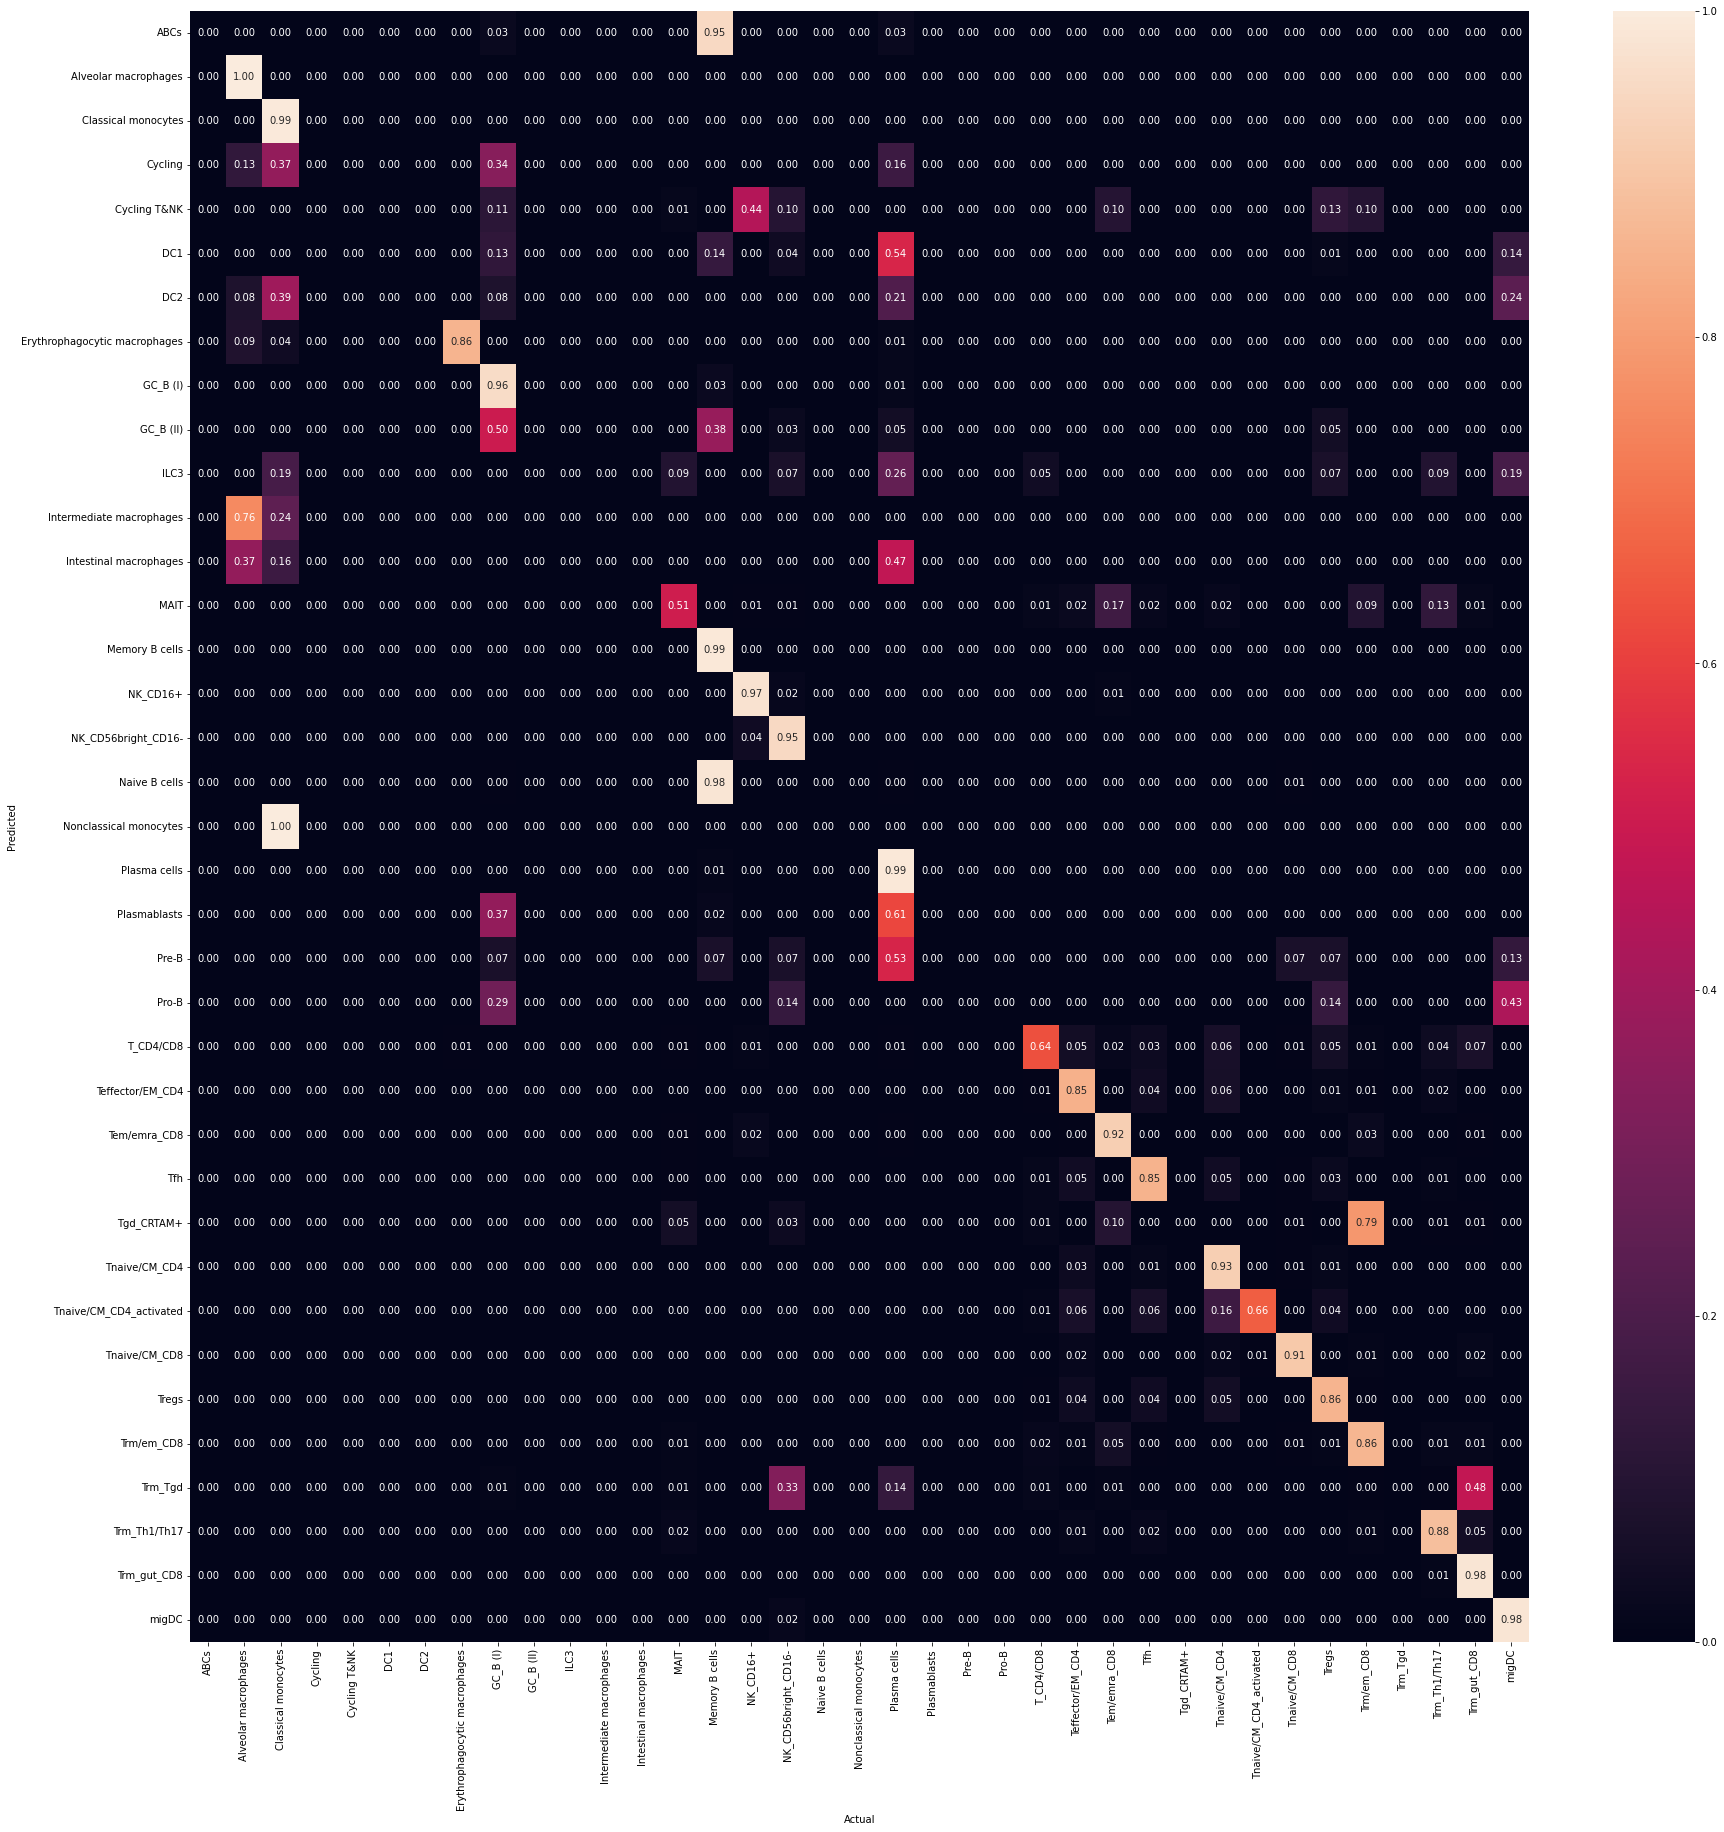

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test = dataset[test_indices].obs['Manually_curated_celltype']
model = results['model']
y_pred = model(torch.tensor(dataset[test_indices].X).cuda()).detach().cpu().numpy()
pred = encoder_celltype.inverse_transform(y_pred.argmax(axis=1))
cm=confusion_matrix(y_test, pred)
# Normalise
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))),
                                    yticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show(block=False)

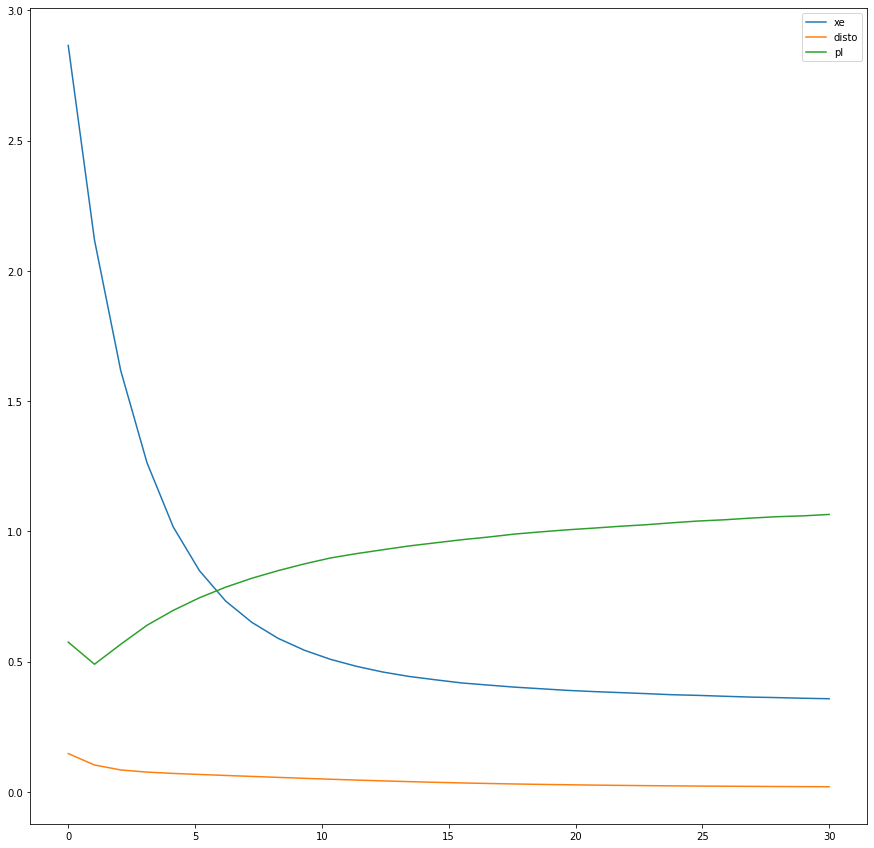

In [21]:
if plot_loss:
    plt.figure(figsize=(15, 15))
    ax = plt.axes()

    x = np.linspace(0, len(results.get('loss_pl')), len(results.get('loss_pl')))
    plt.plot(x, np.array(results.get('loss_xe')), label='xe')
    plt.plot(x, np.array(results.get('loss_disto')), label='disto')
    plt.plot(x, np.array(results.get('loss_pl')), label='pl')
    plt.legend()